In [97]:
from datasets import load_dataset      
import pandas as pd                    
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, auc
from sklearn.metrics import ConfusionMatrixDisplay
import re

### Swapping gender pronouns on Datasets

In [79]:
# read training df
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")['profession']
s_train = pd.read_csv("s_train.csv")

# read val df
X_val = pd.read_csv("X_val.csv")
y_val = pd.read_csv("y_val.csv")['profession']
s_val = pd.read_csv("s_val.csv")

# read test df
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")['profession']
s_test = pd.read_csv("s_test.csv")

In [84]:
def cfa_swap(row_txt):
    gendered_word_dict = {
        'he': 'she', 
        'she': 'he',
        'him': 'her',
        'her': 'him',
        'his': 'her',
        'hers': 'him', 
        'male': 'female',
        'man': 'woman',
        'woman': 'man',
        'female': 'male',
        'father':'mother',
        'mother': 'father',
        'men': 'women',
        'women': 'men',
        "he's" : "she's",
        'hers' : 'his',
        'mr' : 'ms',
        'ms' : 'mr'
    }
    
    pattern = r'\b(' + '|'.join(gendered_word_dict.keys()) + r')\b'
    return re.sub(pattern, lambda m: gendered_word_dict[m.group(0)], row_txt, flags=re.IGNORECASE)

X_val_cfa = pd.DataFrame(X_val['clean_text'].apply(cfa_swap))
X_test_cfa = pd.DataFrame(X_test['clean_text'].apply(cfa_swap))

In [85]:
X_val.head()

,clean_text
0,tampio researches the history of political tho...
1,he has been a practicing dentist for years he ...
2,mr miserez devotes a substantial portion of hi...
3,she holds a master’s degree in nutrition educa...
4,she received her phd in from florida internati...


In [86]:
X_val_cfa.head()

,clean_text
0,tampio researches the history of political tho...
1,she has been a practicing dentist for years sh...
2,ms miserez devotes a substantial portion of he...
3,he holds a master’s degree in nutrition educat...
4,he received him phd in from florida internatio...


In [87]:
print(f"\nBefore CFA: {X_val.iloc[1,0]}\n")
print(f"After CFA: {X_val_cfa.iloc[1,0]}\n")


Before CFA: he has been a practicing dentist for years he is a qualified bds mds orthodontics dentofacial orthopaedics he is currently associated with aesthetic dental care in bapa nagar delhi book an appointment online with dr nitendra singh yadav on lybratecom

After CFA: she has been a practicing dentist for years she is a qualified bds mds orthodontics dentofacial orthopaedics she is currently associated with aesthetic dental care in bapa nagar delhi book an appointment online with dr nitendra singh yadav on lybratecom



In [88]:
s_val_cfa = pd.DataFrame(np.where(np.array(s_val['gender']) == 1, 0, 1), columns = ['cfa_gender'])
s_test_cfa = pd.DataFrame(np.where(np.array(s_test['gender']) == 1, 0, 1), columns = ['cfa_gender'])

In [89]:
# cfa val data exported
X_val_cfa.to_csv("X_val_cfa.csv", index=False)
y_val.to_csv("y_val_cfa.csv", index=False)
s_val_cfa.to_csv("s_val_cfa.csv", index=False)

# cfa test data exported
X_test_cfa.to_csv("X_test_cfa.csv", index=False)
y_test.to_csv("y_test_cfa.csv", index=False)
s_test_cfa.to_csv("s_test_cfa.csv", index=False)

### Testing Augmented Data with Final Baseline Classifier

In [90]:
best_params = (1.0, (1,2), 10)
max_df_, n_gram, C = best_params

pipe_ft = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english', max_df = max_df_, ngram_range = n_gram)),
    ('lr', LogisticRegression(solver='saga', n_jobs=-1, C = C, penalty = 'l2'))
])

pipe_ft.fit(X_train['clean_text'], y_train)

,steps,"[('vectorizer', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [93]:
y_pred = pipe_ft.predict(X_test['clean_text'])
print("Final Test Accuracy Post Finetuning")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:score:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_pred, y_test))

Final Test Accuracy Post Finetuning
Accuracy: 0.8220331284256427
F1:score: 0.7645878638403822
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1193
           1       0.64      0.74      0.69      2189
           2       0.90      0.86      0.88      8491
           3       0.67      0.84      0.74       528
           4       0.72      0.87      0.79       579
           5       0.84      0.78      0.81      1501
           6       0.94      0.94      0.94      3625
           7       0.79      0.84      0.82       932
           8       0.66      0.90      0.76       274
           9       0.79      0.80      0.79      1730
          10       0.59      0.80      0.68       268
          11       0.77      0.68      0.72      5669
          12       0.76      0.81      0.78      1758
          13       0.82      0.87      0.84      4473
          14       0.81      0.80      0.80      1940
          15       0.52      0.95      0.

In [95]:
y_pred_cfa = pipe_ft.predict(X_test_cfa['clean_text'])
print("Final Test Accuracy Post Finetuning")
print("Accuracy:", accuracy_score(y_test, y_pred_cfa))
print("F1:score:", f1_score(y_test, y_pred_cfa, average='macro'))
print(classification_report(y_pred_cfa, y_test))

Final Test Accuracy Post Finetuning
Accuracy: 0.8214678658308855
F1:score: 0.7639288839948598
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1195
           1       0.64      0.74      0.69      2195
           2       0.90      0.86      0.88      8499
           3       0.66      0.85      0.74       514
           4       0.72      0.88      0.79       577
           5       0.84      0.78      0.81      1498
           6       0.94      0.94      0.94      3626
           7       0.79      0.84      0.82       931
           8       0.66      0.90      0.76       275
           9       0.79      0.80      0.79      1731
          10       0.59      0.81      0.68       267
          11       0.77      0.68      0.72      5674
          12       0.76      0.81      0.78      1764
          13       0.80      0.87      0.84      4377
          14       0.81      0.80      0.80      1939
          15       0.51      0.95      0.

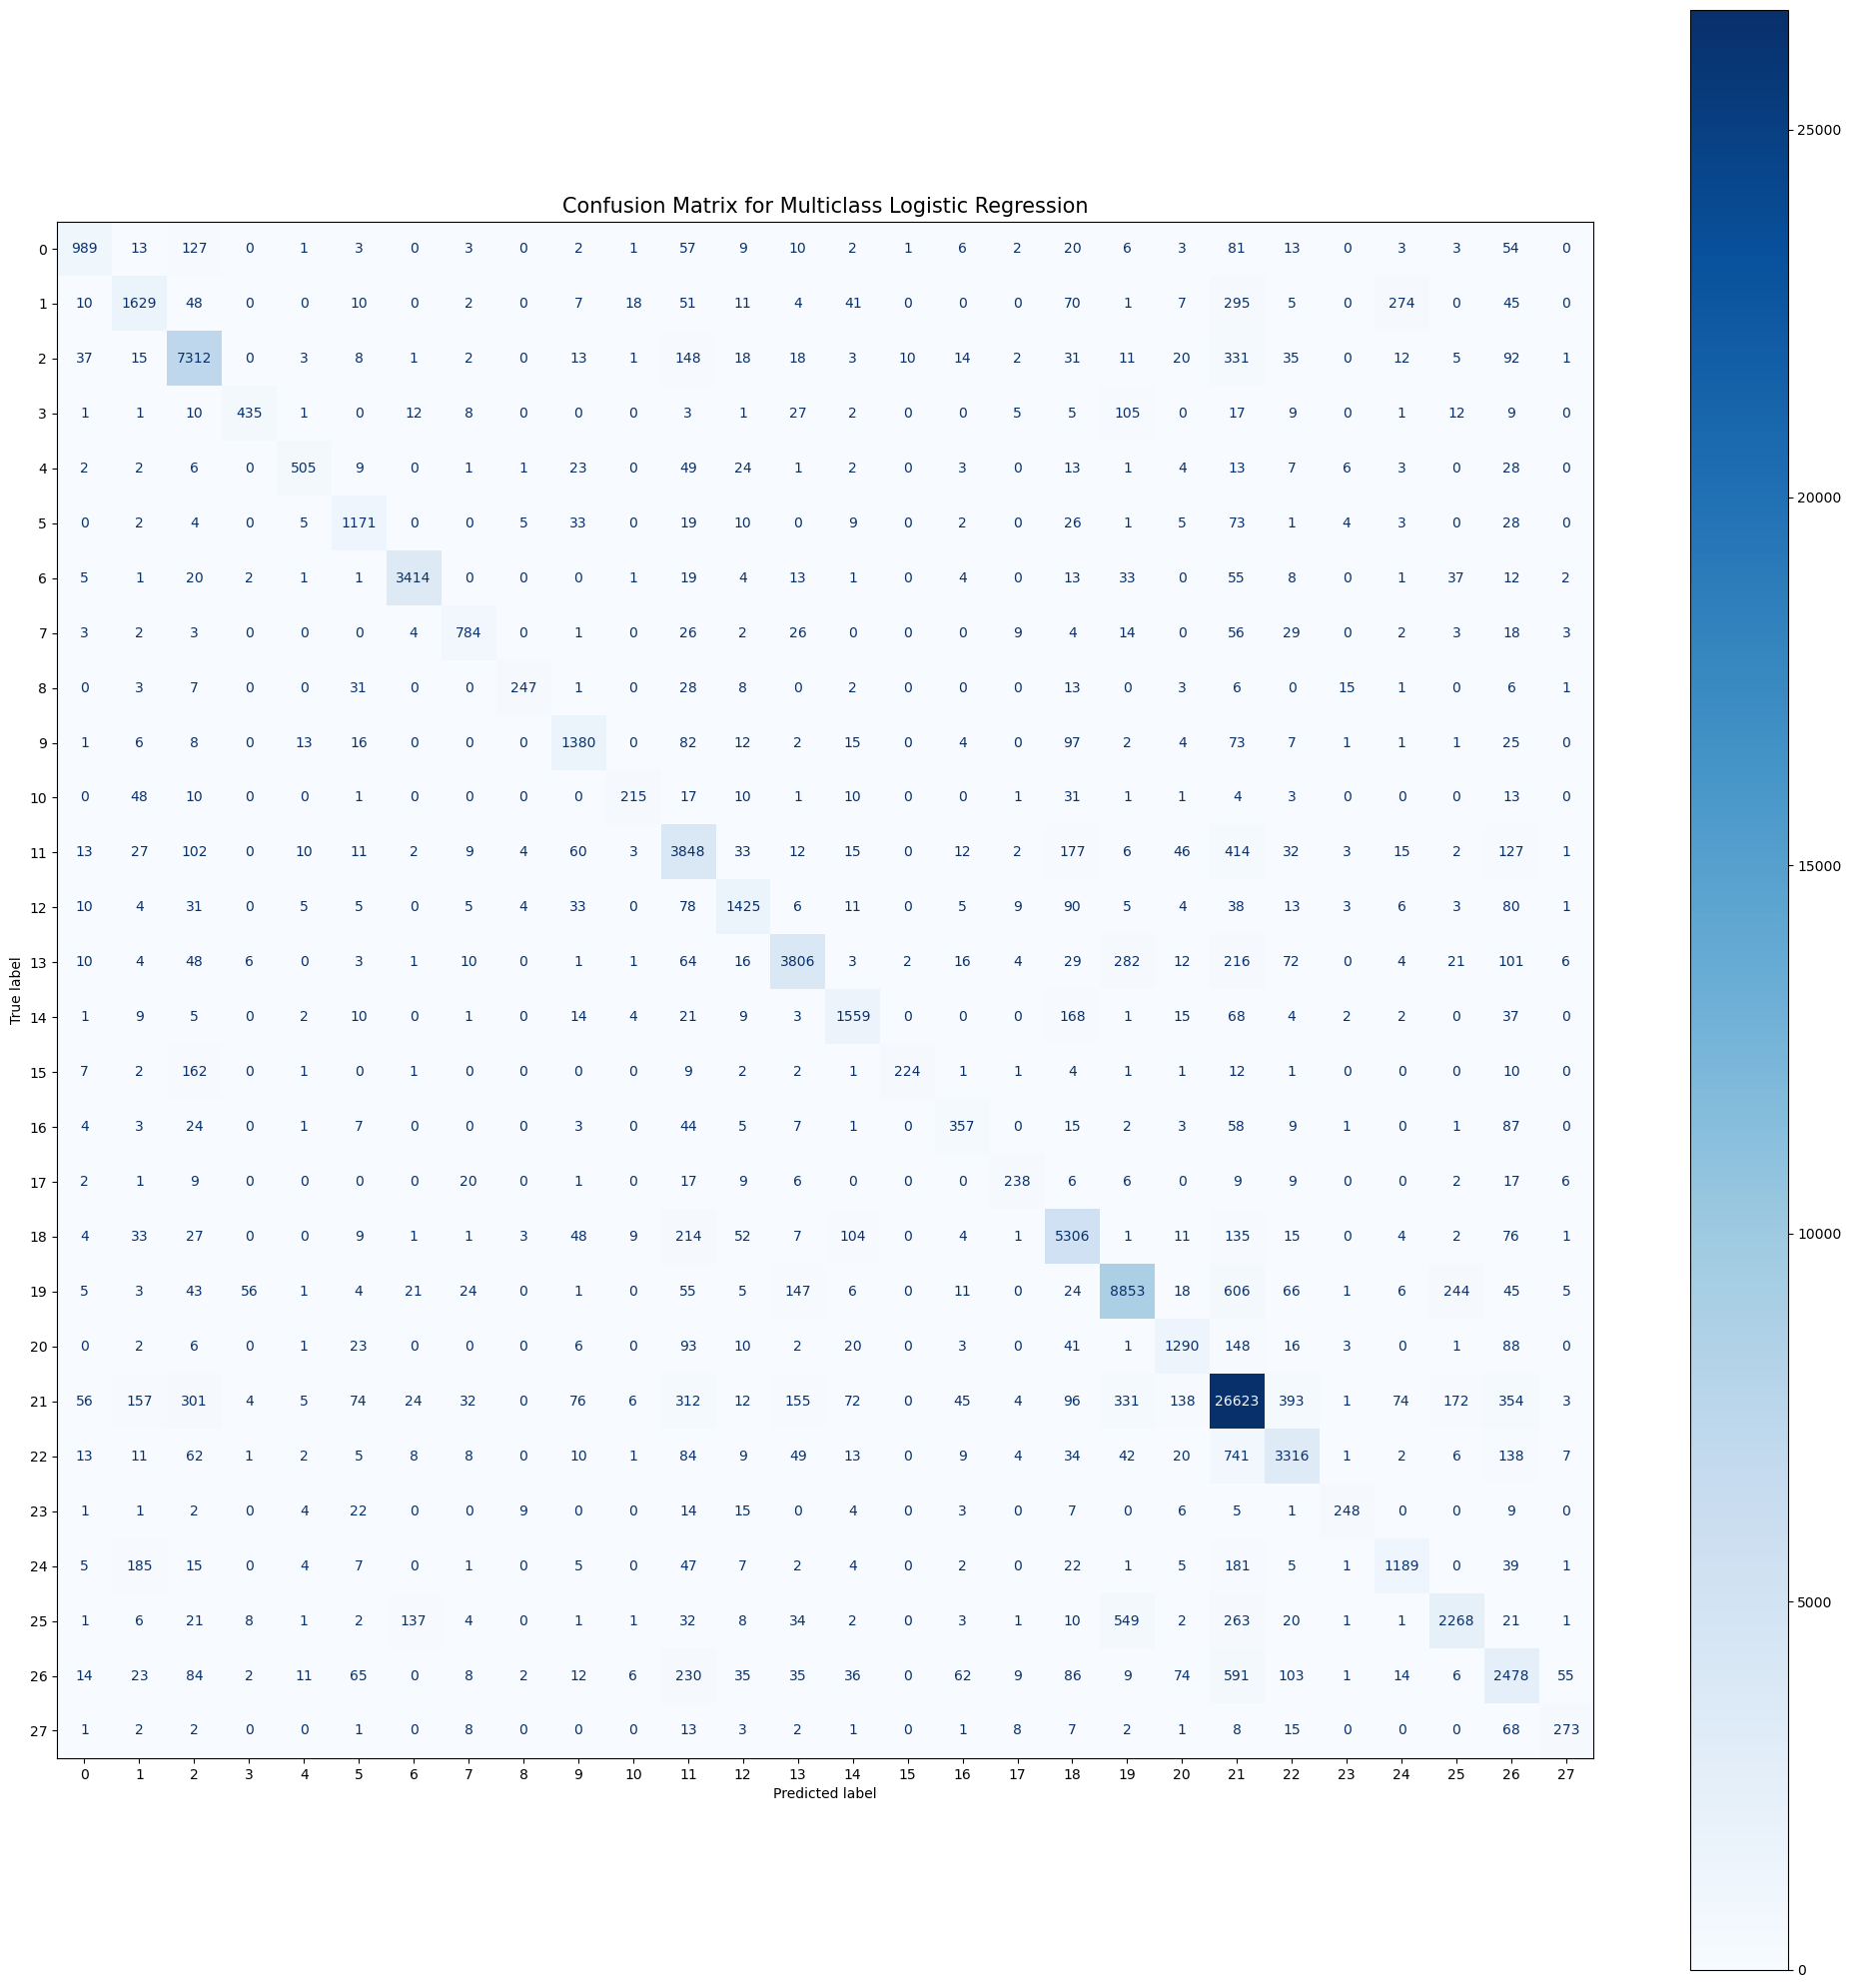

In [100]:
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_estimator(pipe_ft, X_test_cfa['clean_text'], y_test, cmap='Blues', ax= ax)
plt.title("Confusion Matrix for Multiclass Logistic Regression", fontsize = 15)
plt.tight_layout()
plt.show()

In [107]:
male_mask = s_test_cfa['cfa_gender'] == 0
female_mask = s_test_cfa['cfa_gender'] == 1

male_test_y = y_test[male_mask]
female_test_y = y_test[female_mask]

male_ypred = y_pred_cfa[male_mask]
female_ypred = y_pred_cfa[female_mask]

print("\nMale Classification Report of Counter Factual Augmentation Logistic Regression Classifier")
print(classification_report(male_ypred, male_test_y))
print("_"*110)
print("\nFemale Classification Report of Counter Factual Augmentation Logistic Regression Classifier")
print(classification_report(female_ypred, female_test_y))


Male Classification Report of Counter Factual Augmentation Logistic Regression Classifier
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       463
           1       0.67      0.70      0.68       572
           2       0.89      0.84      0.86      3325
           3       0.62      0.78      0.69       139
           4       0.68      0.85      0.76       120
           5       0.86      0.69      0.76       286
           6       0.94      0.94      0.94      1288
           7       0.81      0.88      0.84       840
           8       0.58      0.84      0.69        37
           9       0.78      0.78      0.78       578
          10       0.60      0.86      0.71       204
          11       0.78      0.71      0.75      2711
          12       0.83      0.90      0.86      1438
          13       0.81      0.90      0.85      3848
          14       0.80      0.81      0.80       871
          15       0.53      0.96      0.69 

In [105]:
def class_accuracy(y_pred, y_true):
    accuracy = []
    for c in range(28):
        mask = y_true == c
        accuracy.append(accuracy_score(y_true[mask], y_pred[mask]))
    return accuracy

total_accuracy = class_accuracy(y_pred_cfa, y_test)
male_accuracy = class_accuracy(male_ypred, male_test_y)
female_accuracy = class_accuracy(female_ypred, female_test_y)
diff_accuracy = np.array(male_accuracy) - np.array(female_accuracy)
absdiff_accuracy = np.abs(diff_accuracy)

In [114]:
print(f"Difference Accuracy between Gender CFA: {diff_accuracy.mean()}")

Difference Accuracy between Gender CFA: 0.024154215278754193


In [113]:
print(f"Absolute Difference of Accuracy between Gender CFA: {absdiff_accuracy.mean()}")

Absolute Difference of Accuracy between Gender CFA: 0.07691157913918532


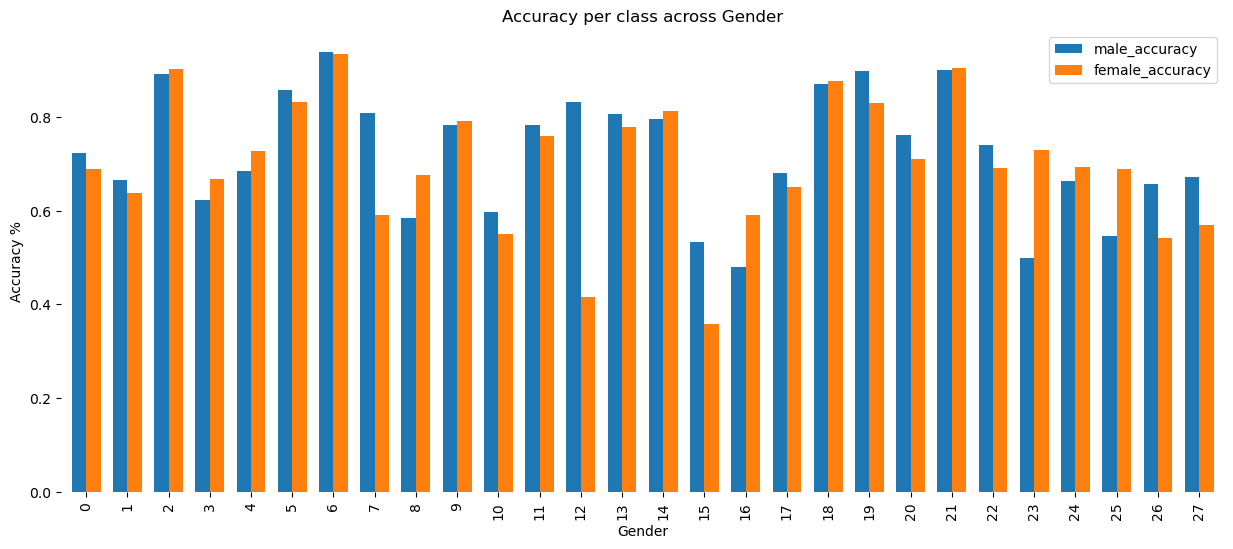

In [106]:
group = list(range(28))
accuracy_df = pd.DataFrame({
    "group" : group,
    "male_accuracy": male_accuracy,
    "female_accuracy": female_accuracy
})

accuracy_df.set_index('group').plot(kind='bar',
                                    width=0.7,
                                    figsize=(15, 6),
                                    title ="Accuracy per class across Gender",
                                    ylabel = "Accuracy %",
                                    xlabel = "Gender"
                                   )
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)

Counterfactual augmentation slightly adjusts some class-level performance differences, but overall accuracy and macro metrics remain similar. The accuracy of the test set without CFA is 82.20% and with CFA is 82.14%. This means that CFA did not harm the models performance and it still generalizes after the augmentation. The gap between the F1 - macro difference remained the same of 0.03. In the baseline, the male was 0.03 less than female f1 and after cfa it flipped with it being 0.03 between male and female. Applying CFA on the baseline did not change the accuracy much but it made the classes slightly more symmetrical. 